# Projet : Construire un modèle de scoring

___

## Notebook Modélisation & interprétabilité

Ce notebook met en œuvre la suite logique du projet de scoring, en commençant par la définition d’un score métier qui reflète le coût asymétrique des erreurs (faux négatifs vs faux positifs) et l’optimisation du seuil de décision. Il intègre ensuite la mise en place d’un pipeline de modélisation avec gestion du déséquilibre des classes et recherche d’hyperparamètres via GridSearchCV, afin de comparer différents algorithmes selon des critères techniques (AUC, accuracy) et métier. Enfin, il propose une analyse d’interprétabilité à la fois globale et locale (avec SHAP), pour expliquer clairement aux chargés de relation client les facteurs qui influencent chaque prédiction.

---

---

---

---

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_curve,
    roc_auc_score, accuracy_score,
    make_scorer
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline       import Pipeline as ImbPipeline
from sklearn.metrics         import fbeta_score, make_scorer, roc_auc_score, accuracy_score
from sklearn.metrics import fbeta_score, make_scorer


app_train_domain = pd.read_csv('application_train.csv', sep=',')
app_test_domain  = pd.read_csv('application_test.csv',  sep=',')

# features 1
app_train_domain['CREDIT_INCOME_PERCENT']  = app_train_domain['AMT_CREDIT']   / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY']  / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM']            = app_train_domain['AMT_ANNUITY']  / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT']  = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']


In [266]:
features = [
    'CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT',
    'CREDIT_TERM','DAYS_EMPLOYED_PERCENT',
    'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'
]
X = app_train_domain[features].fillna(0)
y = app_train_domain['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)


In [267]:
def cout_metier(y_true, y_pred, cout_FN=10, cout_FP=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn * cout_FN + fp * cout_FP

assert cout_metier([0,1,0,1],[0,0,1,1]) == 10+1


In [268]:
scorer_metier = make_scorer(cout_metier, greater_is_better=False)


In [269]:
baseline_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    LogisticRegression(
                   solver='lbfgs', max_iter=1000,
                   class_weight='balanced'))
])

scores_baseline = cross_val_score(
    baseline_pipe, X_train, y_train,
    scoring=scorer_metier,
    cv=5, n_jobs=-1
)
print("Coût métier CV baseline :", np.mean(scores_baseline))



Coût métier CV baseline : -30161.6


In [270]:
param_grid = {
    'clf__C':       [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2']
}

grid = GridSearchCV(
    estimator=baseline_pipe,
    param_grid=param_grid,
    scoring=scorer_metier,
    cv=5, n_jobs=-1
)
grid.fit(X_train, y_train)

best_pipe = grid.best_estimator_
print("Meilleurs paramètres :", grid.best_params_)
print("Coût métier CV optimisé :", grid.best_score_)

Meilleurs paramètres : {'clf__C': 10, 'clf__penalty': 'l2'}
Coût métier CV optimisé : -30161.2


In [271]:
proba_test = best_pipe.predict_proba(X_test)[:,1]
fpr, tpr, seuils = roc_curve(y_test, proba_test)

costs = [cout_metier(y_test, (proba_test>=s).astype(int)) for s in seuils]
idx_opt, seuil_opt = int(np.argmin(costs)), seuils[np.argmin(costs)]
cost_opt = costs[idx_opt]

print(f"Seuil optimal : {seuil_opt:.4f} → Coût minimal : {cost_opt}")


Seuil optimal : 0.5082 → Coût minimal : 37144


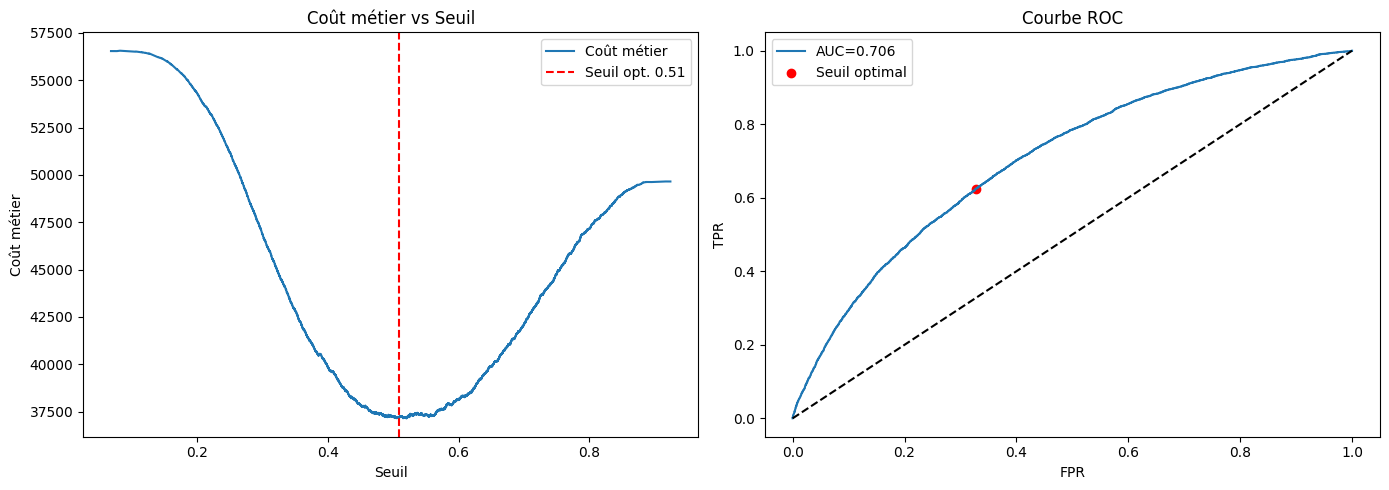

In [272]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

axes[0].plot(seuils, costs, label='Coût métier')
axes[0].axvline(seuil_opt, color='red', linestyle='--',
                label=f'Seuil opt. {seuil_opt:.2f}')
axes[0].set_xlabel('Seuil')
axes[0].set_ylabel('Coût métier')
axes[0].set_title('Coût métier vs Seuil')
axes[0].legend()

axes[1].plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test,proba_test):.3f}')
axes[1].scatter(fpr[idx_opt], tpr[idx_opt], color='red', label='Seuil optimal')
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].set_title('Courbe ROC')
axes[1].legend()

plt.tight_layout()
plt.show()


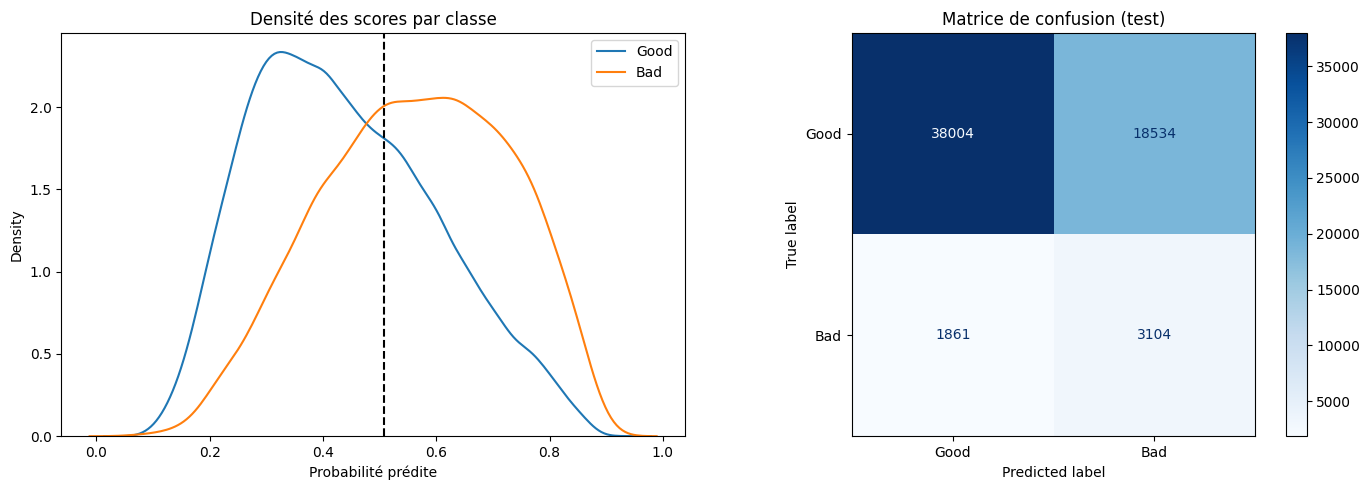

In [273]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

sns.kdeplot(proba_test[y_test==0], label='Good', ax=axes[0])
sns.kdeplot(proba_test[y_test==1], label='Bad',  ax=axes[0])
axes[0].axvline(seuil_opt, color='black', linestyle='--')
axes[0].set_title('Densité des scores par classe')
axes[0].set_xlabel('Probabilité prédite')
axes[0].legend()

y_pred_opt = (proba_test >= seuil_opt).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt,
    display_labels=['Good','Bad'],
    cmap='Blues', ax=axes[1])
axes[1].set_title('Matrice de confusion (test)')

plt.tight_layout()
plt.show()


In [274]:
cost_final = cout_metier(y_test, y_pred_opt)
auc_final  = roc_auc_score(y_test, proba_test)
acc_final  = accuracy_score(y_test, y_pred_opt)

print(f"Coût métier final : {cost_final}")
print(f"AUC (test)        : {auc_final:.4f}")
print(f"Accuracy (test)   : {acc_final:.4f}")


Coût métier final : 37144
AUC (test)        : 0.7059
Accuracy (test)   : 0.6684


---

---

## 3. Tests et comparaison de modèles

Nous comparons plusieurs algorithmes, du plus simple au plus complexe, en gérant le déséquilibre de classes et en évaluant via Cross-Validation.

In [276]:
print("Shape X_train:", X_train.shape, "Shape X_test:", X_test.shape)

Shape X_train: (246008, 7) Shape X_test: (61503, 7)


In [278]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier, GradientBoostingClassifier
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier

from sklearn.pipeline        import Pipeline
from imblearn.pipeline       import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import (
    fbeta_score, make_scorer,
    roc_auc_score, accuracy_score, roc_curve
)

In [279]:
scorer_f1   = make_scorer(fbeta_score, beta=1)
def cout_metier(y_true, y_pred, cout_FN=10, cout_FP=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn*cout_FN + fp*cout_FP

In [280]:
models = {
    'LogisticRegression': {
        'pipe': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(
                class_weight='balanced', max_iter=1000, solver='lbfgs'))
        ]),
        'params': {'clf__C': [0.01, 0.1, 1, 10]}
    },
    'DecisionTree': {
        'pipe': Pipeline([
            ('clf', DecisionTreeClassifier(
                class_weight='balanced', random_state=42))
        ]),
        'params': {
            'clf__max_depth': [5, 10],
            'clf__min_samples_split': [2, 5]
        }
    },
    'RandomForest': {
        'pipe': Pipeline([
            ('clf', RandomForestClassifier(
                class_weight='balanced', random_state=42))
        ]),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [5, 10]
        }
    },
    'GradientBoosting': {
        'pipe': Pipeline([
            ('clf', GradientBoostingClassifier(random_state=42))
        ]),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1]
        }
    },
    'XGBoost': {
        'pipe': Pipeline([
            ('clf', XGBClassifier(
                objective='binary:logistic', use_label_encoder=False,
                eval_metric='auc', scale_pos_weight=10, random_state=42))
        ]),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [3, 5]
        }
    },
    'LightGBM': {
        'pipe': Pipeline([
            ('clf', LGBMClassifier(
                objective='binary', class_weight='balanced', random_state=42))
        ]),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__num_leaves': [31, 64]
        }
    }
}

In [281]:
import time
from sklearn.metrics import recall_score, precision_score

best_pipes = {}
results    = []

for name, cfg in models.items():
    print(f"Entraînement de {name}…")
    # Mesurer le temps
    t0 = time.time()
    gs = GridSearchCV(
        estimator   = cfg['pipe'],
        param_grid  = cfg['params'],
        scoring     = scorer_f1,
        cv          = 3,
        n_jobs      = -1
    )
    gs.fit(X_train, y_train)
    fit_time = time.time() - t0
    
    best_pipes[name] = gs.best_estimator_
    
    # Prédictions et métriques
    t1   = time.time()
    proba = best_pipes[name].predict_proba(X_test)[:,1]
    pred  = (proba >= 0.5).astype(int)
    eval_time = time.time() - t1
    
    results.append({
        'Model':           name,
        'Params':          gs.best_params_,
        'F1_score':        fbeta_score(y_test, pred, beta=1),
        'Precision_score': precision_score(y_test, pred),
        'Recall_score':    recall_score(y_test, pred),
        'AUC_score':       roc_auc_score(y_test, proba),
        'Accuracy_score':  accuracy_score(y_test, pred),
        'Cost_score':      cout_metier(y_test, pred),
        'Fit_time':        fit_time,
        'Eval_time':       eval_time
    })

df_results = pd.DataFrame(results).set_index('Model')
display(df_results)



Entraînement de LogisticRegression…


Entraînement de DecisionTree…
Entraînement de RandomForest…
Entraînement de GradientBoosting…
Entraînement de XGBoost…


c:\Users\Gui\Desktop\AAA_doc\Openclassroom school\Python project\proj_proj\proj4\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:58:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entraînement de LightGBM…
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,Params,F1_score,AUC_score,Accuracy_score,Cost_score
Model,,,,,
LogisticRegression,{'clf__C': 10},0.230948,0.705913,0.656082,37253
DecisionTree,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.239767,0.709209,0.665106,36050
RandomForest,"{'clf__max_depth': 10, 'clf__n_estimators': 200}",0.256888,0.736281,0.704437,34585
GradientBoosting,"{'clf__learning_rate': 0.1, 'clf__n_estimators...",0.030196,0.754572,0.919581,48938
XGBoost,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.277901,0.753421,0.734680,32743
LightGBM,"{'clf__learning_rate': 0.1, 'clf__n_estimators...",0.269324,0.750089,0.715038,33141


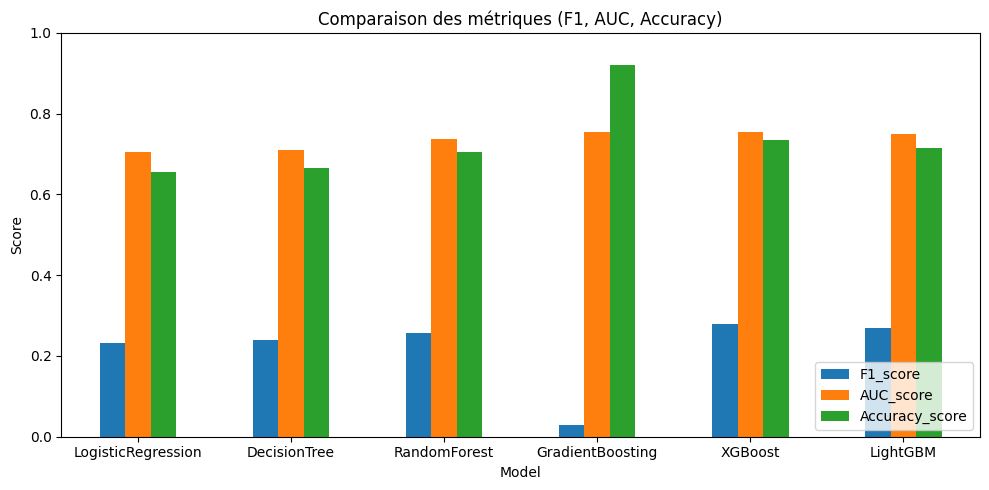

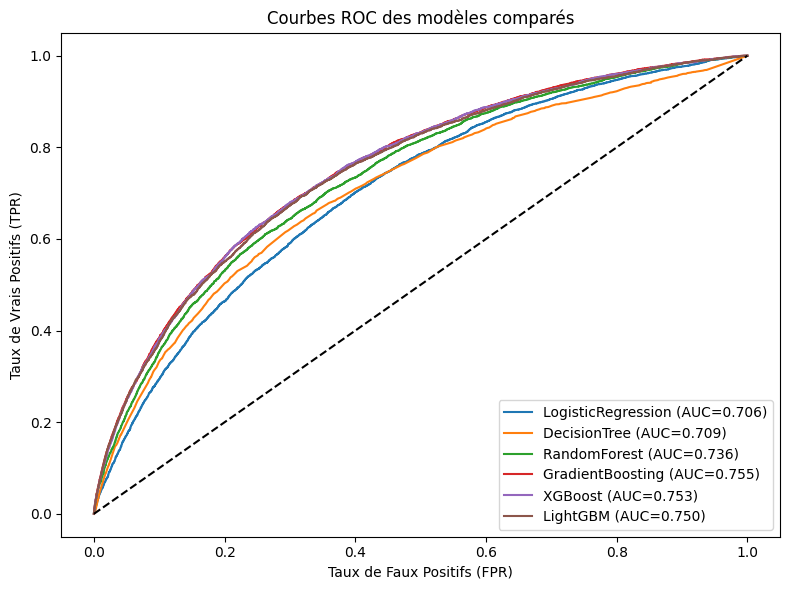

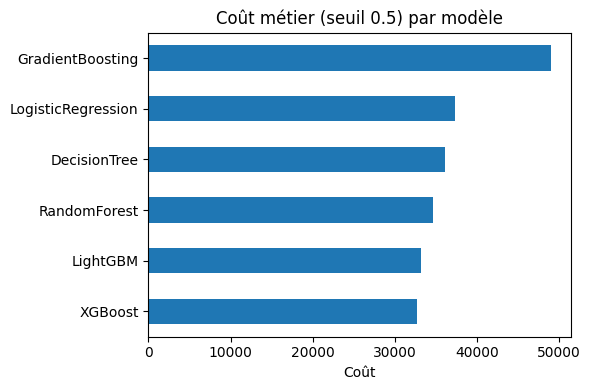

In [286]:
df_results[['F1_score','AUC_score','Accuracy_score']].plot(
    kind='bar', figsize=(10,5), rot=0
)
plt.title("Comparaison des métriques (F1, AUC, Accuracy)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for name, pipe in best_pipes.items():
    proba = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={df_results.loc[name,'AUC_score']:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC des modèles comparés')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


costs = {name: cout_metier(y_test, (pipe.predict_proba(X_test)[:,1]>=0.5).astype(int))
         for name, pipe in best_pipes.items()}
pd.Series(costs, name='Cost_score').sort_values().plot(
    kind='barh', figsize=(6,4)
)
plt.title("Coût métier (seuil 0.5) par modèle")
plt.xlabel("Coût")
plt.tight_layout()
plt.show()


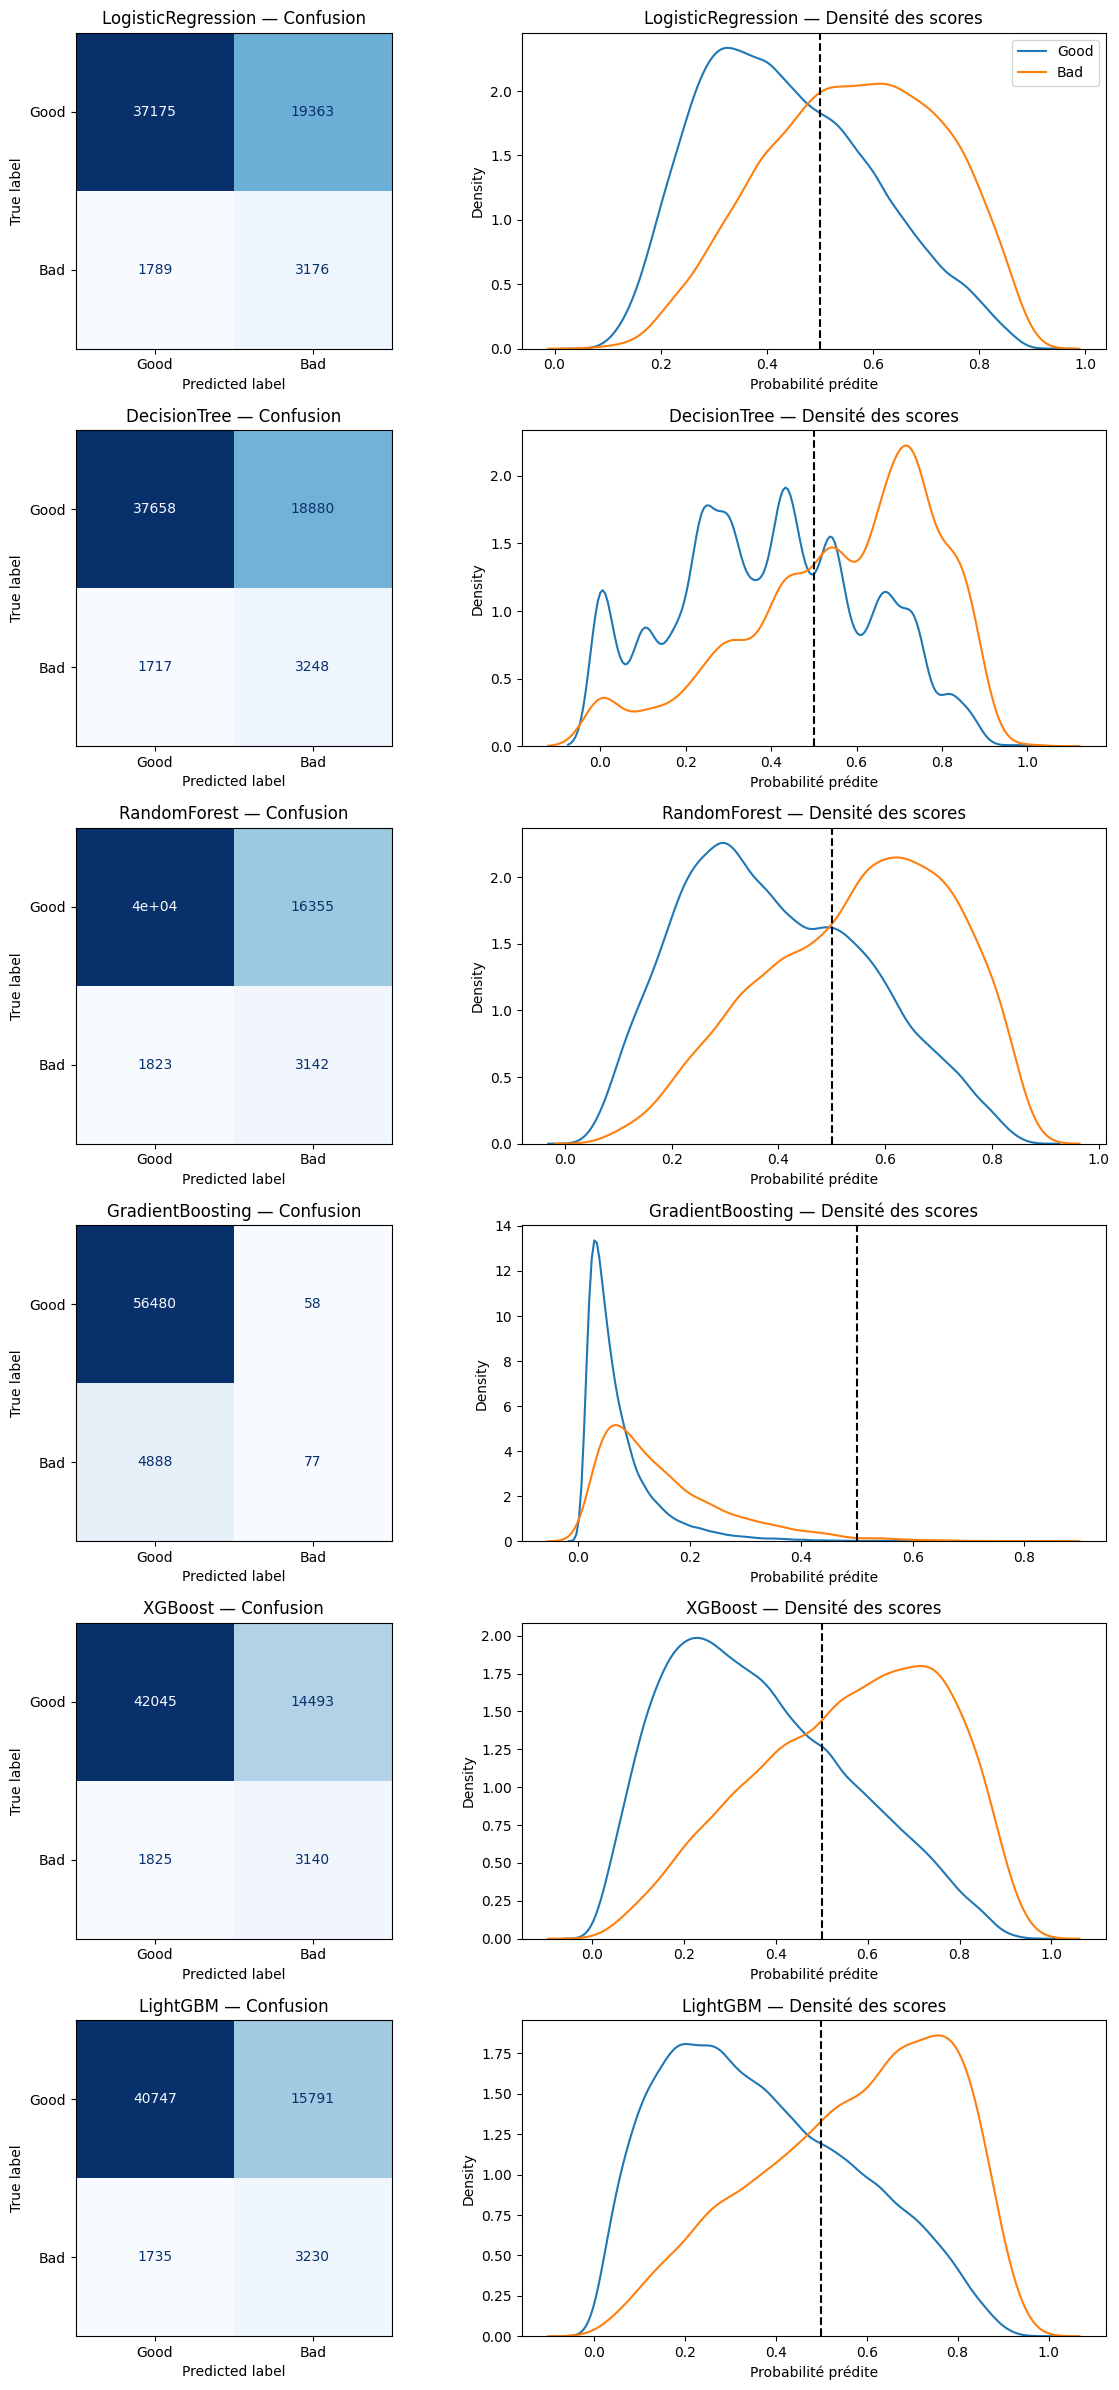

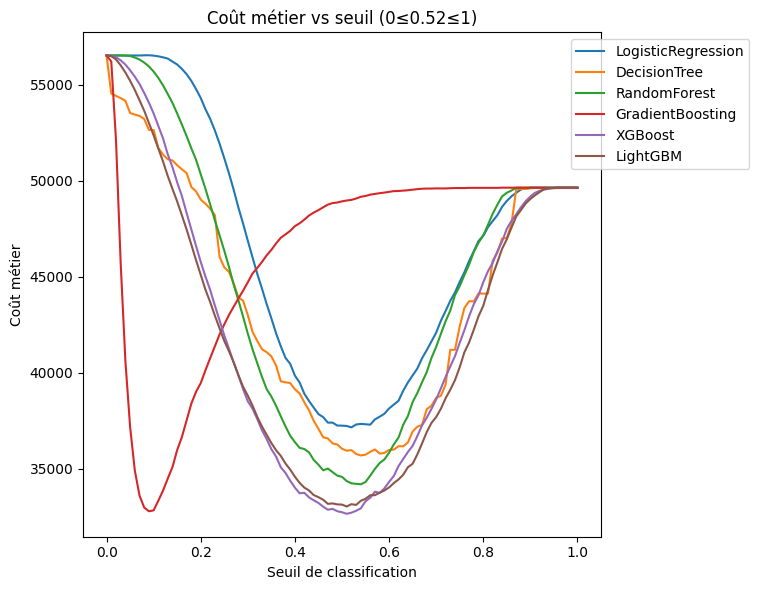

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve


models = list(best_pipes.keys())
n = len(models)

fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
for i, name in enumerate(models):
    pipe = best_pipes[name]
    proba = pipe.predict_proba(X_test)[:,1]
    pred  = (proba >= 0.5).astype(int)
    
    ax_cm = axes[i,0]
    ConfusionMatrixDisplay.from_predictions(
        y_test, pred,
        display_labels=['Good','Bad'],
        cmap='Blues', ax=ax_cm, colorbar=False
    )
    ax_cm.set_title(f"{name} — Confusion")

    ax_den = axes[i,1]
    sns.kdeplot(proba[y_test==0], label='Good', ax=ax_den)
    sns.kdeplot(proba[y_test==1], label='Bad',  ax=ax_den)
    ax_den.axvline(0.5, color='black', linestyle='--')
    ax_den.set_title(f"{name} — Densité des scores")
    ax_den.set_xlabel("Probabilité prédite")
    if i==0: ax_den.legend(loc='upper right')

plt.tight_layout()
plt.show()

thresholds = np.linspace(0, 1, 101)
fig, ax = plt.subplots(figsize=(8,6))
for name in models:
    pipe = best_pipes[name]
    proba = pipe.predict_proba(X_test)[:,1]
    costs = [
        cout_metier(y_test, (proba >= t).astype(int))
        for t in thresholds
    ]
    ax.plot(thresholds, costs, label=name)

ax.set_title("Coût métier vs seuil (0≤0.52≤1)")
ax.set_xlabel("Seuil de classification")
ax.set_ylabel("Coût métier")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()


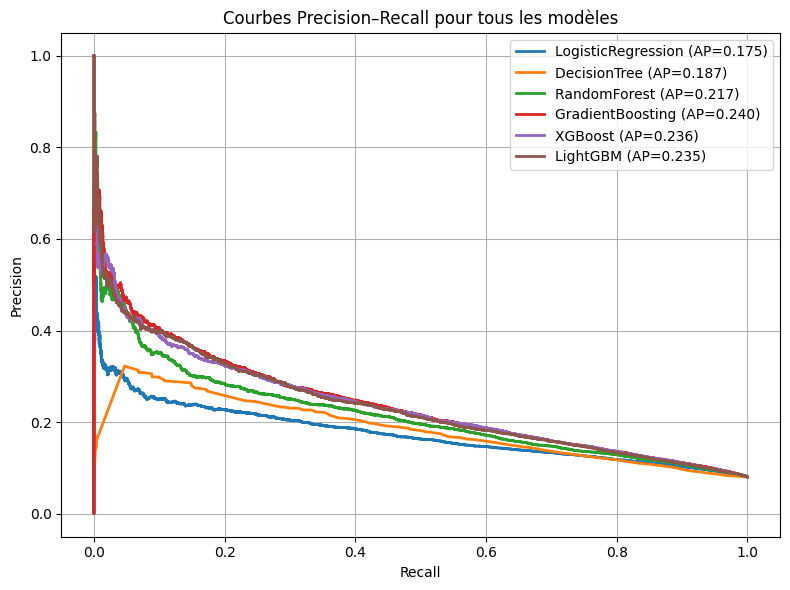

In [319]:
plt.figure(figsize=(8,6))

for name, pipe in best_pipes.items():
    proba    = pipe.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap       = average_precision_score(y_test, proba)
    plt.plot(recall, precision, lw=2, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbes Precision–Recall pour tous les modèles")
plt.grid(True)

plt.legend(loc="upper right")  

plt.tight_layout()
plt.show()


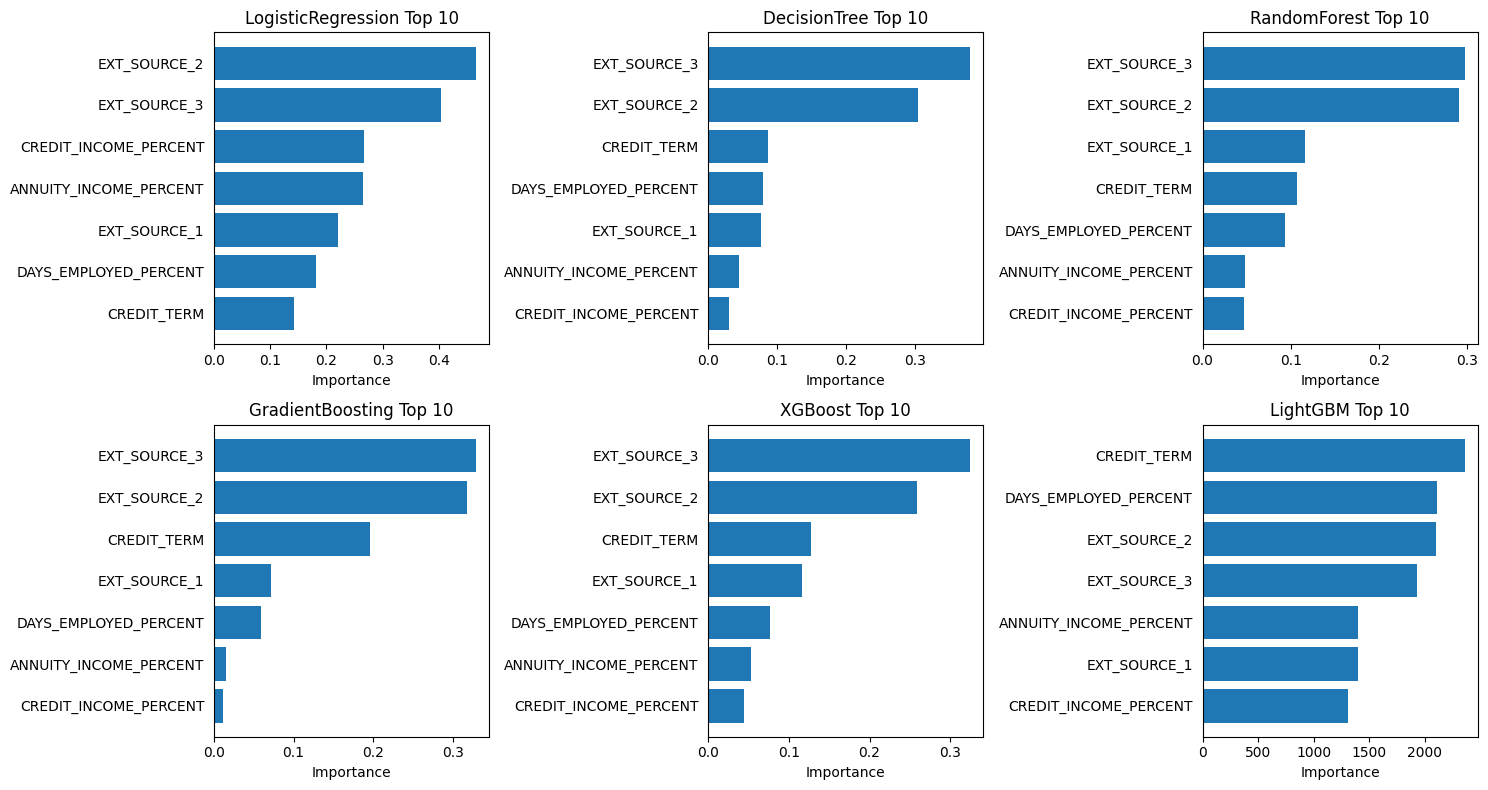

In [284]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = X_train.columns.tolist()
models = list(best_pipes.keys())
n_models = len(models)
ncols = 3
nrows = (n_models + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

for ax, name in zip(axes, models):
    pipe = best_pipes[name]
    clf  = pipe.named_steps['clf']
    
    if hasattr(clf, 'feature_importances_'):
        imp = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        imp = np.abs(clf.coef_[0])
    else:
        ax.set_visible(False)
        continue
    
    idxs = np.argsort(imp)[::-1][:10]
    names = np.array(feature_names)[idxs]
    vals  = imp[idxs]
    
    ax.barh(names[::-1], vals[::-1])
    ax.set_title(f"{name} Top 10")
    ax.set_xlabel("Importance")
    ax.tick_params(left=False, labelleft=True)
    
for ax in axes[n_models:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


---

---

## 4. Shap et Lime : explicabilité et interprétation

In [300]:
import shap
import lime
import lime.lime_tabular

In [348]:
best_costs = {}
best_thresholds = {}

for name, pipe in best_pipes.items():
    proba = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    costs = [cout_metier(y_test, (proba>=t).astype(int)) for t in thresholds]
    idx = np.argmin(costs)
    best_costs[name] = costs[idx]
    best_thresholds[name] = thresholds[idx]

pd.DataFrame({
    'AUC'      : {n: roc_auc_score(y_test, best_pipes[n].predict_proba(X_test)[:,1]) for n in best_pipes},
    'Cost_min' : best_costs,
    'Threshold': best_thresholds
}).sort_values('Cost_min')


,AUC,Cost_min,Threshold
XGBoost,0.753421,32599,0.506631
GradientBoosting,0.754572,32737,0.089805
LightGBM,0.750089,32997,0.505583
RandomForest,0.736281,34152,0.516697
DecisionTree,0.709209,35680,0.541246
LogisticRegression,0.705913,37144,0.508165


In [350]:
best_costs = {}
best_thresholds = {}

for name, pipe in best_pipes.items():
    proba = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    costs = [cout_metier(y_test, (proba>=t).astype(int)) for t in thresholds]
    idx = np.argmin(costs)
    best_costs[name]      = costs[idx]
    best_thresholds[name] = thresholds[idx]

df_compare = pd.DataFrame({
    'AUC_score' : {n: roc_auc_score(y_test, best_pipes[n].predict_proba(X_test)[:,1]) for n in best_pipes},
    'Cost_min'  : best_costs,
    'Threshold' : best_thresholds
}).sort_values('Cost_min')

best_model_name = df_compare.index[0]
print("Modèle retenu (coût minimal) :", best_model_name)
print(df_compare.loc[best_model_name])


Modèle retenu (coût minimal) : XGBoost
AUC_score        0.753421
Cost_min     32599.000000
Threshold        0.506631
Name: XGBoost, dtype: float64


GradientBoosting n'est pas retenu pour sont coût trop elevé et sont seuil trop bas 

Modèle retenu (sans GB) : XGBoost
AUC_score        0.753421
Cost_min     32599.000000
Threshold        0.506631
Name: XGBoost, dtype: float64


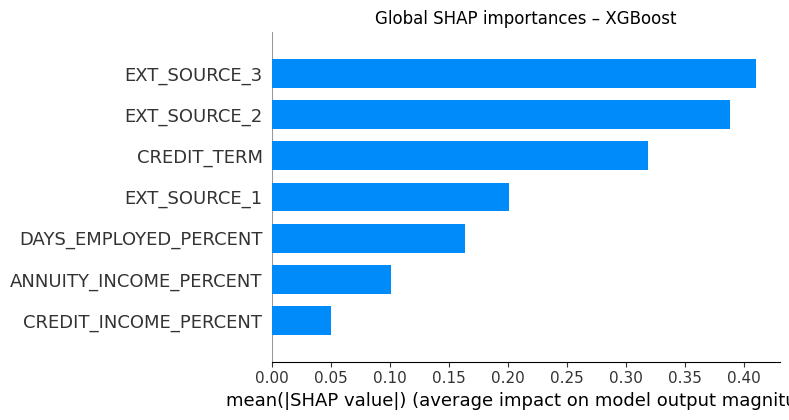

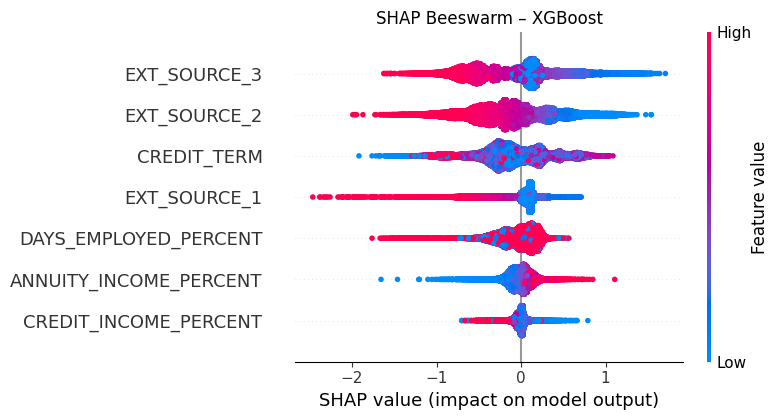

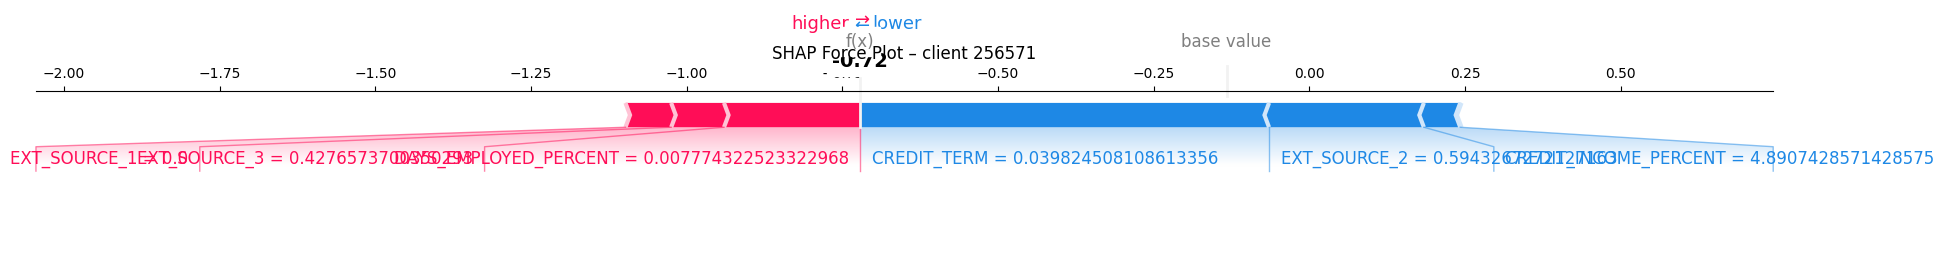

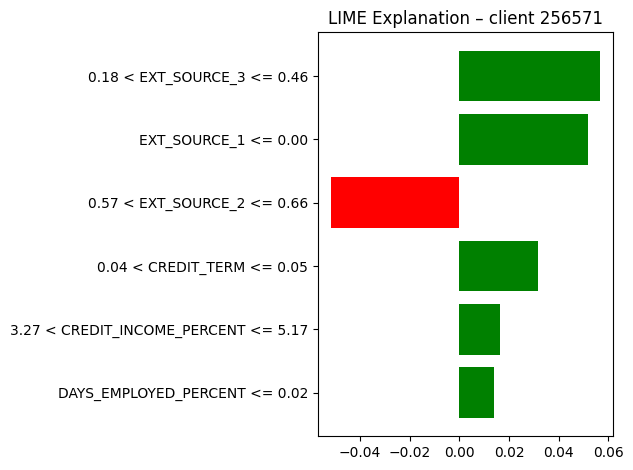

In [352]:
if 'GradientBoosting' in df_compare.index:
    df_compare = df_compare.drop('GradientBoosting')
if 'GradientBoosting' in best_pipes:
    best_pipes.pop('GradientBoosting')

best_model_name = df_compare['Cost_min'].idxmin()
print("Modèle retenu (selon AUC et coût minimal) :", best_model_name)

print(df_compare.loc[best_model_name])

pipe_final = best_pipes[best_model_name]
clf_final  = pipe_final.named_steps['clf']
scaler     = pipe_final.named_steps.get('scaler', None)

X_int = X_test.copy()
if scaler:
    X_scaled = scaler.transform(X_int)
    X_scaled = pd.DataFrame(X_scaled, columns=X_int.columns, index=X_int.index)
else:
    X_scaled = X_int

# SHAP global
explainer = shap.TreeExplainer(clf_final)
sv = explainer.shap_values(X_scaled)
if isinstance(sv, list):
    shap_vals = sv[1]
    exp_val   = explainer.expected_value[1]
else:
    shap_vals = sv
    exp_val   = explainer.expected_value

plt.figure(figsize=(8,4))
shap.summary_plot(shap_vals, X_scaled, plot_type='bar', max_display=10, show=False)
plt.title(f"Global SHAP importances – {best_model_name}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
shap.summary_plot(shap_vals, X_scaled, max_display=10, show=False)
plt.title(f"SHAP Beeswarm – {best_model_name}")
plt.tight_layout()
plt.show()

# SHAP local
idx = X_scaled.index[0]
row_i = X_scaled.index.get_loc(idx)
shap.initjs()
shap.force_plot(
    exp_val,
    shap_vals[row_i,:],
    X_scaled.iloc[row_i,:],
    feature_names=X_scaled.columns,
    matplotlib=True, show=False
)
plt.title(f"SHAP Force Plot – client {idx}")
plt.tight_layout()
plt.show()

# LIME local
explainer_lime = LimeTabularExplainer(
    training_data   = X_train.values,
    feature_names   = X_train.columns.tolist(),
    class_names     = ['Good','Bad'],
    mode            = 'classification',
    discretize_continuous=True
)
exp = explainer_lime.explain_instance(
    data_row     = X_int.loc[idx].values,
    predict_fn   = clf_final.predict_proba,
    num_features = 6
)
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation – client {idx}")
plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

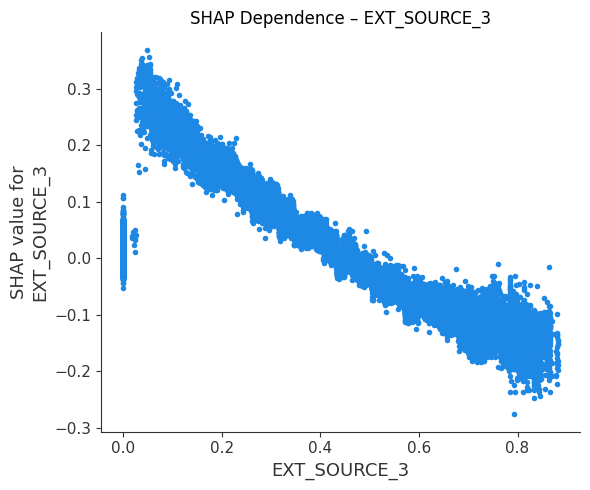

<Figure size 600x400 with 0 Axes>

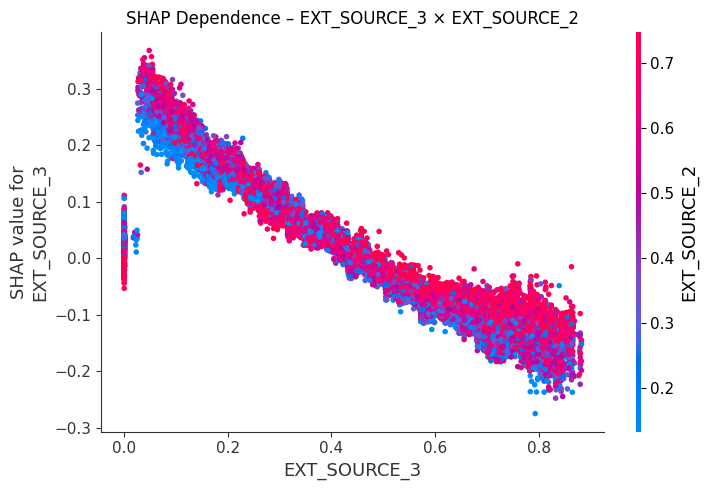

In [392]:
# Plot pour la feature la plus importante
top_feat = df_compare.index[0]
plt.figure(figsize=(6,4))
shap.dependence_plot(
    'EXT_SOURCE_3',     
    sv,                    
    X_scaled,             
    interaction_index=None,
    show=False
)
plt.title("SHAP Dependence – EXT_SOURCE_3")
plt.tight_layout()
plt.show()

# Plot (EXT_SOURCE_3 vs EXT_SOURCE_2)
plt.figure(figsize=(6,4))
shap.dependence_plot(
    'EXT_SOURCE_3',
    sv,
    X_scaled,
    interaction_index='EXT_SOURCE_2',
    show=False
)
plt.title("SHAP Dependence – EXT_SOURCE_3 × EXT_SOURCE_2")
plt.tight_layout()
plt.show()


Test sur client :


--- Explication pour Good_typique (index 287975) ---



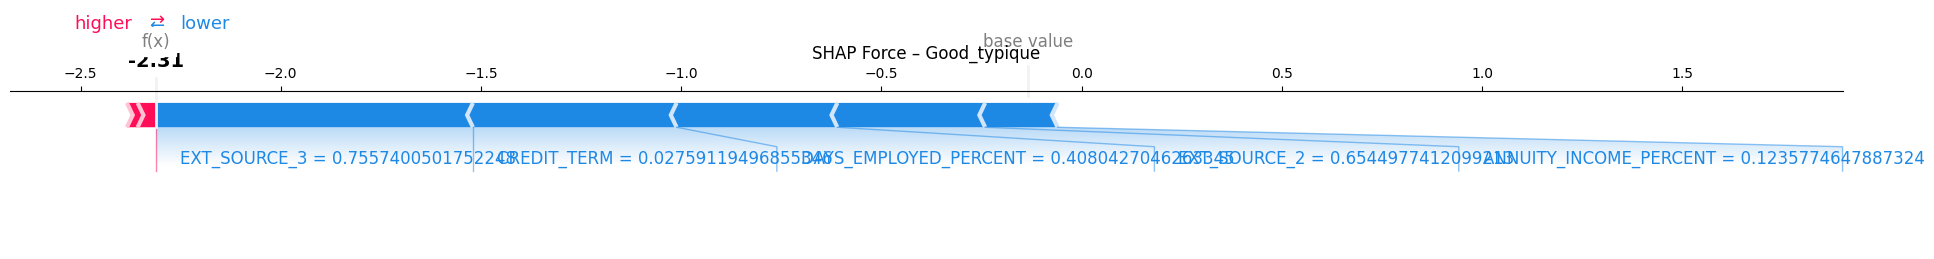

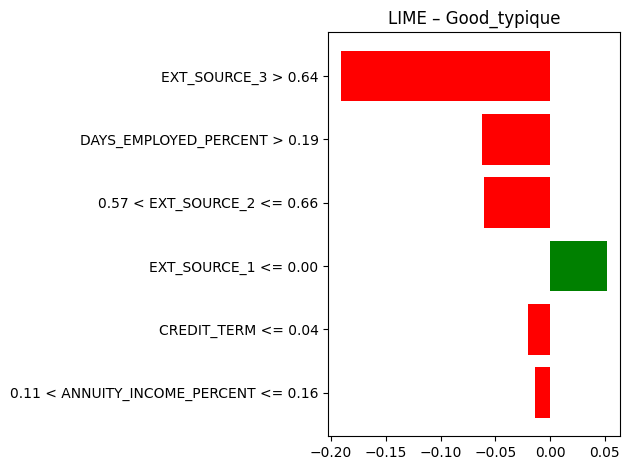


--- Explication pour Bad_typique (index 235663) ---



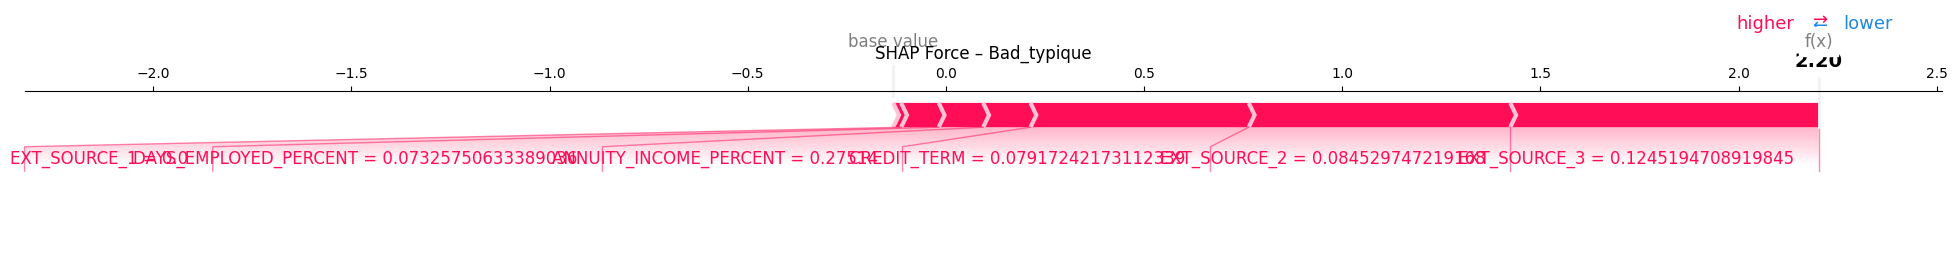

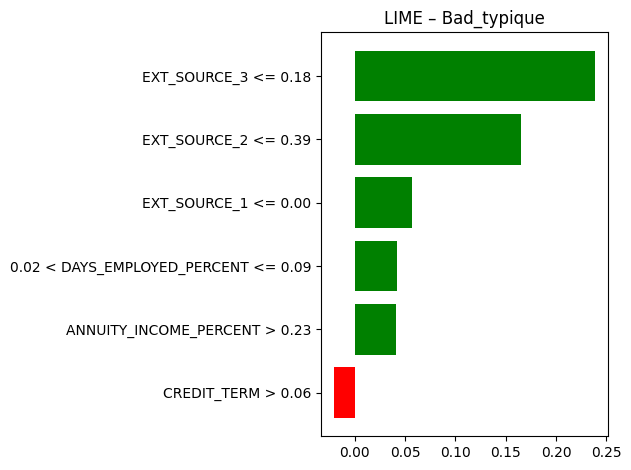


--- Explication pour Borderline (index 74343) ---



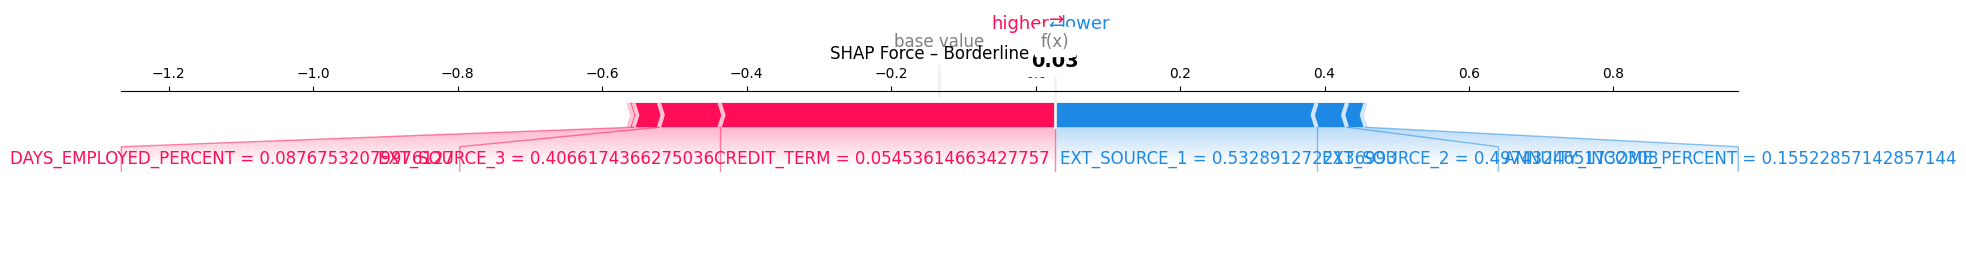

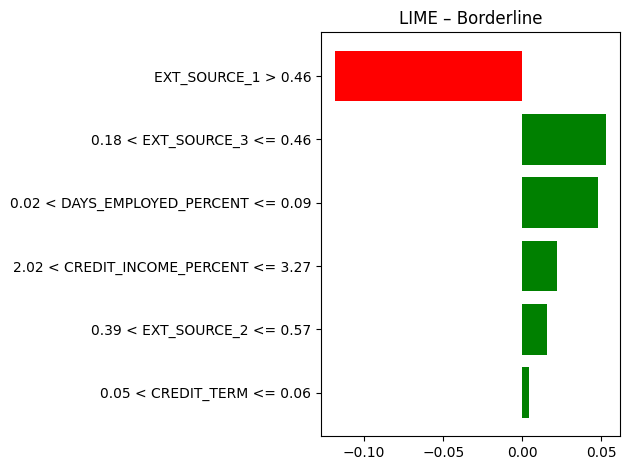

In [353]:
probas = pipe_final.predict_proba(X_test)[:,1]
seuil = df_compare.loc[best_model_name,'Threshold']

# 3 types de proba
idx_good      = X_test[probas < 0.1].index[0]    
idx_bad       = X_test[probas > 0.9].index[0]    
idx_border    = (np.abs(probas - seuil)).argmin()  
idx_border    = X_test.index[idx_border]

clients = {
    'Good_typique': idx_good,
    'Bad_typique' : idx_bad,
    'Borderline'  : idx_border
}

for label, idx in clients.items():
    print(f"\n--- Explication pour {label} (index {idx}) ---\n")
    
    # SHAP
    row_i = X_scaled.index.get_loc(idx)
    shap.initjs()
    fig = shap.force_plot(
        exp_val,
        shap_vals[row_i,:],
        X_scaled.iloc[row_i,:],
        feature_names=X_scaled.columns,
        matplotlib=True,
        show=False
    )
    plt.title(f"SHAP Force – {label}")
    plt.tight_layout()
    plt.show()
    
    # LIME
    exp = explainer_lime.explain_instance(
        data_row     = X_int.loc[idx].values,
        predict_fn   = clf_final.predict_proba,
        num_features = 6
    )
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME – {label}")
    plt.tight_layout()
    plt.show()


Test sur 3 types de client, avec explaibn

In [385]:
def report_client(idx, label, return_df=False):
    pos = X_scaled.index.get_loc(idx)
    p   = probas[pos]
    contrib = sv[pos, :]
    df = pd.DataFrame({
        'feature': X_scaled.columns,
        'shap':    contrib
    })
    df['abs'] = df['shap'].abs()
    df = df.sort_values('abs', ascending=False).head(7).reset_index(drop=True)
    
    if return_df:
        return df[['feature','shap']]
    
    colors = ['red' if v>0 else 'green' for v in df['shap']]
    plt.figure(figsize=(6,3))
    plt.barh(df['feature'], df['shap'], color=colors)
    plt.axvline(0, color='black', linewidth=1)
    plt.title(f"{label} – proba défaut = {p:.1%} (seuil={seuil_opt:.2f})")
    plt.xlabel("Effet sur la probabilité")
    plt.tight_layout()
    plt.show()
    
    df2 = df.copy()
    df2['impact'] = df2['shap'].apply(lambda v: '↑ risque' if v>0 else '↓ risque')
    display(df2)
    print(f"Client {label} – probabilité défaut : {p:.1%}\n")
    for _, r in df2.iterrows():
        print(f" • {r.feature}: {r.shap:.3f} ({r.impact})")
    print("\n" + "-"*60 + "\n")


ExactExplainer explainer: 61504it [09:49, 102.56it/s]                           


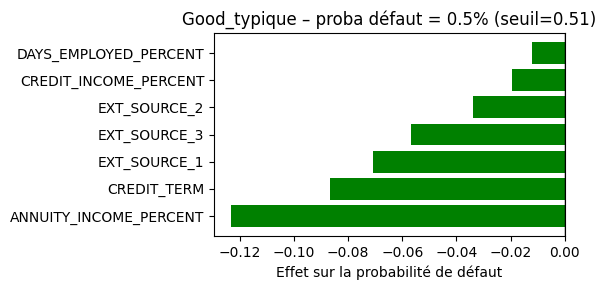

,feature,shap,impact
1,ANNUITY_INCOME_PERCENT,-0.123385,↓ risque
2,CREDIT_TERM,-0.086580,↓ risque
4,EXT_SOURCE_1,-0.070757,↓ risque
6,EXT_SOURCE_3,-0.056673,↓ risque
5,EXT_SOURCE_2,-0.033837,↓ risque
0,CREDIT_INCOME_PERCENT,-0.019653,↓ risque
3,DAYS_EMPLOYED_PERCENT,-0.012095,↓ risque


Client Good_typique – probabilité défaut : 0.5%

 • ANNUITY_INCOME_PERCENT: -0.123 (↓ risque)
 • CREDIT_TERM: -0.087 (↓ risque)
 • EXT_SOURCE_1: -0.071 (↓ risque)
 • EXT_SOURCE_3: -0.057 (↓ risque)
 • EXT_SOURCE_2: -0.034 (↓ risque)
 • CREDIT_INCOME_PERCENT: -0.020 (↓ risque)
 • DAYS_EMPLOYED_PERCENT: -0.012 (↓ risque)

------------------------------------------------------------



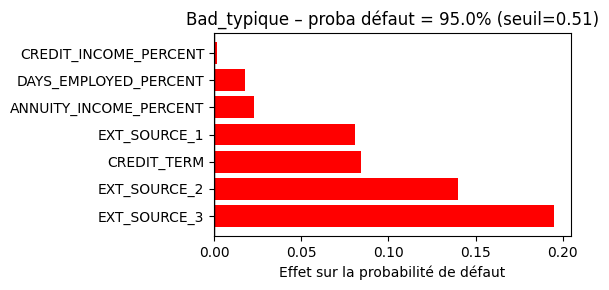

,feature,shap,impact
6,EXT_SOURCE_3,0.194922,↑ risque
5,EXT_SOURCE_2,0.139742,↑ risque
2,CREDIT_TERM,0.084322,↑ risque
4,EXT_SOURCE_1,0.080675,↑ risque
1,ANNUITY_INCOME_PERCENT,0.023166,↑ risque
3,DAYS_EMPLOYED_PERCENT,0.017752,↑ risque
0,CREDIT_INCOME_PERCENT,0.001695,↑ risque


Client Bad_typique – probabilité défaut : 95.0%

 • EXT_SOURCE_3: 0.195 (↑ risque)
 • EXT_SOURCE_2: 0.140 (↑ risque)
 • CREDIT_TERM: 0.084 (↑ risque)
 • EXT_SOURCE_1: 0.081 (↑ risque)
 • ANNUITY_INCOME_PERCENT: 0.023 (↑ risque)
 • DAYS_EMPLOYED_PERCENT: 0.018 (↑ risque)
 • CREDIT_INCOME_PERCENT: 0.002 (↑ risque)

------------------------------------------------------------



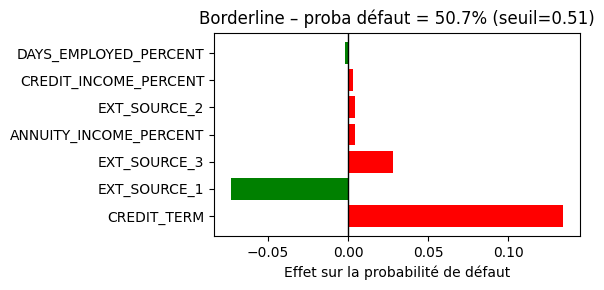

,feature,shap,impact
2,CREDIT_TERM,0.134293,↑ risque
4,EXT_SOURCE_1,-0.073166,↓ risque
6,EXT_SOURCE_3,0.027898,↑ risque
1,ANNUITY_INCOME_PERCENT,0.004316,↑ risque
5,EXT_SOURCE_2,0.004206,↑ risque
0,CREDIT_INCOME_PERCENT,0.002886,↑ risque
3,DAYS_EMPLOYED_PERCENT,-0.001692,↓ risque


Client Borderline – probabilité défaut : 50.7%

 • CREDIT_TERM: 0.134 (↑ risque)
 • EXT_SOURCE_1: -0.073 (↓ risque)
 • EXT_SOURCE_3: 0.028 (↑ risque)
 • ANNUITY_INCOME_PERCENT: 0.004 (↑ risque)
 • EXT_SOURCE_2: 0.004 (↑ risque)
 • CREDIT_INCOME_PERCENT: 0.003 (↑ risque)
 • DAYS_EMPLOYED_PERCENT: -0.002 (↓ risque)

------------------------------------------------------------



In [389]:
# 3 profils clients -> Good, Bad, Borderline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

best_model = df_compare['Cost_min'].idxmin()
pipe_final = best_pipes[best_model]
clf_final  = pipe_final.named_steps['clf']
scaler     = pipe_final.named_steps.get('scaler', None)
seuil_opt  = df_compare.loc[best_model, 'Threshold']

X_int = X_test.copy()
if scaler:
    arr = scaler.transform(X_int)
else:
    arr = X_int.values
X_scaled = pd.DataFrame(arr, columns=X_int.columns, index=X_int.index)

probas = pipe_final.predict_proba(X_int)[:,1]
idx_good   = X_int.index[np.argmin(probas)]
idx_bad    = X_int.index[np.argmax(probas)]
idx_border = X_int.index[np.argmin(np.abs(probas - seuil_opt))]

clients = {
    'Good_typique': idx_good,
    'Bad_typique':  idx_bad,
    'Borderline':   idx_border
}

# Shap
expl = shap.Explainer(clf_final.predict_proba, X_scaled, output_names=['Good','Bad'])
sv = expl(X_scaled).values[:,:,1] 


def report_client(idx, label):
    pos = X_scaled.index.get_loc(idx)
    p   = probas[pos]
    contrib = sv[pos,:]
    df = pd.DataFrame({
        'feature': X_scaled.columns,
        'shap':    contrib
    })
    df['abs'] = df['shap'].abs()
    df = df.sort_values('abs', ascending=False).head(7)
    
    # Barplot
    colors = ['red' if v>0 else 'green' for v in df['shap']]
    plt.figure(figsize=(6,3))
    plt.barh(df['feature'], df['shap'], color=colors)
    plt.axvline(0, color='black', linewidth=1)
    plt.title(f"{label} – proba défaut = {p:.1%} (seuil={seuil_opt:.2f})")
    plt.xlabel("Effet sur la probabilité de défaut")
    plt.tight_layout()
    plt.show()
    
    # Tableau
    df2 = df[['feature','shap']].copy()
    df2['impact'] = df2['shap'].apply(lambda v: '↑ risque' if v>0 else '↓ risque')
    display(df2)
    print(f"Client {label} – probabilité défaut : {p:.1%}\n")
    for _, r in df2.iterrows():
        print(f" • {r.feature}: {r.shap:.3f} ({r.impact})")
    print("\n" + "-"*60 + "\n")

for label, idx in clients.items():
    report_client(idx, label)


---